In [1]:
# code modified from here:
# https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Full-Archive-Tweet-Counts/full_archive_tweet_counts.py

import os
import json
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
import datetime
import seaborn as sns

In [2]:
savefig_settings = {'bbox_inches': 'tight', 'facecolor': 'w', 'dpi': 150}
idx = pd.IndexSlice
save_fig = False

## check results of automatic labeling

In [3]:
tweets_classified_df = pd.read_csv("../classifier/tweets_classified2_annotated.csv", index_col=0)
print(len(tweets_classified_df))

1467983


In [4]:
# convert created_at to pd time object
def convert_str_to_datetime(datetime_string):
    return datetime.datetime.strptime(datetime_string ,"%Y-%m-%dT%H:%M:%S.%fZ")

tweets_classified_df['created_at'] = tweets_classified_df['created_at'].apply(convert_str_to_datetime)

In [5]:
# aggregate category labels

keywords_df = pd.read_csv("../data-download/Geoengineering keywords for Twitter query - review.csv", header=[1])
keywords_filtered = keywords_df[keywords_df["action after second update"] == "keep"]
subquery_ids = keywords_filtered["subquery_id"].values

for cat in keywords_filtered['category'].unique():
    print(cat)
    sids = keywords_filtered[keywords_filtered['category'] == cat]["subquery_id"].values
    tweets_classified_df[cat] = (tweets_classified_df[sids].sum(axis=1) > 0).map({True: 1, False: 0})

General
SRM
GGR


In [6]:
tweets_classified_df.head()

tid         uid          created_at  \
lid                                                       
1    647551397802737664   245959308 2015-09-25 23:20:58   
2    647551151932506113  3323067952 2015-09-25 23:20:00   
3    647549503877156864    15533969 2015-09-25 23:13:27   
4    647549277401649152   245959308 2015-09-25 23:12:33   
5    647548980533022720   245959308 2015-09-25 23:11:22   

                                                  text cardiff-stance-climate  \
lid                                                                             
1    @lorabruncke @WHO @OpChemtrails @UN lie #COP21...                   none   
2    Geoengineering And The Dying Of The Trees http...                  favor   
3    @TerminatorBarbi @Airahairick @mrbangla @rocke...                  favor   
4    @OpChemtrails @UN lie #COP21 lie @Greenpeace l...                   none   
5    @canpoli @UN lie #COP21 lie @Greenpeace lie ex...                   none   

    cardiff-offensive cardiff-sentiment bertweet-sentiment geomotions-orig  \
lid                                                                          
1           offensive          negative           negative        surprise   
2       not-offensive           neutral           negative        surprise   
3       not-offensive          negative            neutral       confusion   
4           offensive          negative           negative        surprise   
5           offensive          negative           negative        surprise   

    geomotions-ekman  ... c_47 c_48 retweet_count reply_count  like_count  \
lid                   ...                                                   
1            neutral  ...    0    0             1           0           0   
2            neutral  ...    0    0             0           0           0   
3            neutral  ...    0    0             0           2           0   
4            neutral  ...    0    0             2           1           2   
5            neutral  ...    0    0             0           0           0   

     quote_count  conspiracy-filter  General  SRM  GGR  
lid                                                     
1              0               True        1    0    0  
2              0              False        1    0    0  
3              0              False        1    0    0  
4              0               True        1    0    0  
5              0               True        1    0    0  

[5 rows x 101 columns]

In [7]:
tweets_classified_df.columns

Index(['tid', 'uid', 'created_at', 'text', 'cardiff-stance-climate',
       'cardiff-offensive', 'cardiff-sentiment', 'bertweet-sentiment',
       'geomotions-orig', 'geomotions-ekman',
       ...
       'c_47', 'c_48', 'retweet_count', 'reply_count', 'like_count',
       'quote_count', 'conspiracy-filter', 'General', 'SRM', 'GGR'],
      dtype='object', length=101)

In [8]:
# count retweets, replies, likes, quotes

tweets_classified_df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum()

retweet_count    1924166
reply_count       461766
like_count       4268598
quote_count       192376
dtype: int64

In [9]:
tweets_classified_df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum() / len(tweets_classified_df)

retweet_count    1.310755
reply_count      0.314558
like_count       2.907798
quote_count      0.131048
dtype: float64

## map high dimensional emotions

In [19]:
tweets_classified_df['geomotions-ekman-tertiary'] = tweets_classified_df['geomotions-ekman'].map({'neutral': 'neutral',
                                               'joy': 'positive',
                                                'surprise': 'neutral',
                                                'anger': 'negative',
                                                'fear': 'negative',
                                                'sadness': 'negative',
                                                'disgust': 'negative'})

In [20]:
tweets_classified_df['cardiff-emotion-tertiary'] = tweets_classified_df['cardiff-emotion'].map({
'optimism': 'neutral',
'anger': 'negative',
'sadness': 'negative',
'joy': 'positive'
})

In [21]:
tweets_classified_df["nrc-highest-tertiary"] = tweets_classified_df["nrc-highest"].map({
'neutral': 'neutral',
'positive': 'positive',
'negative': 'negative',
'fear': 'negative',
'trust': 'positive',
'anger': 'negative',
'anticipation': 'positive',
'surprise': 'neutral',
'sadness': 'negative',
'disgust': 'negative',
'joy': 'positive'
})

In [22]:
tweets_classified_df["bertweet-emotions-tertiary"] = tweets_classified_df["bertweet-emotions"].map({
'others': 'neutral',
'disgust': 'negative',
'joy': 'positive',
'fear': 'negative',
'anger': 'negative',
'surprise': 'neutral',
'sadness': 'negative'})

In [23]:
# compare: cardiff-sentiment, bertweet-sentiment, geomotions-ekman,
# cardiff-emotion, bertweet-emotions, nrc-

In [24]:
tweets_classified_df[['cardiff-sentiment', 'bertweet-sentiment', 'nrc-highest-tertiary',
'cardiff-emotion-tertiary', 'geomotions-ekman-tertiary', 'bertweet-emotions-tertiary']]

cardiff-sentiment bertweet-sentiment nrc-highest-tertiary  \
lid                                                                 
1                negative           negative             negative   
2                 neutral           negative              neutral   
3                negative            neutral             positive   
4                negative           negative             negative   
5                negative           negative             negative   
...                   ...                ...                  ...   
1467979           neutral            neutral             negative   
1467980           neutral            neutral             positive   
1467981           neutral            neutral              neutral   
1467982          positive            neutral             positive   
1467983           neutral            neutral             positive   

        cardiff-emotion-tertiary geomotions-ekman-tertiary  \
lid                                                          
1                       negative                   neutral   
2                       negative                   neutral   
3                       negative                   neutral   
4                       negative                   neutral   
5                       negative                   neutral   
...                          ...                       ...   
1467979                  neutral                   neutral   
1467980                  neutral                   neutral   
1467981                 negative                   neutral   
1467982                  neutral                   neutral   
1467983                  neutral                  positive   

        bertweet-emotions-tertiary  
lid                                 
1                         negative  
2                          neutral  
3                         negative  
4                         negative  
5                         negative  
...                            ...  
1467979                    neutral  
1467980                    neutral  
1467981                    neutral  
1467982                    neutral  
1467983                    neutral  

[1467983 rows x 6 columns]

## user analysis

Text(0.5, 0, 'number of tweets')

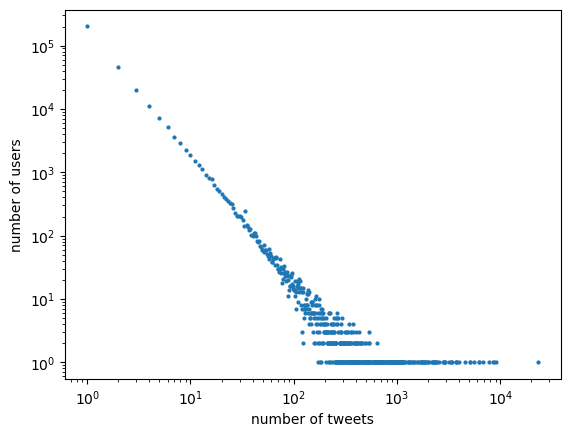

In [25]:
# distribution of tweeting activity
histogram = tweets_classified_df['uid'].value_counts().value_counts()
plt.scatter(histogram.index, histogram.values, s=4)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('number of users')
plt.xlabel('number of tweets')
#plt.savefig("figures/users/tweets_per_user_histogram.png", **savefig_settings)

In [30]:
tweets_per_user = tweets_classified_df['uid'].value_counts()
n = len(tweets_per_user)

# how much do the top 1% of active users contribute
print("top 1%", tweets_per_user.iloc[0:int(n / 100)].sum() / len(tweets_classified_df))

# how much do the top 10% of active users contribute
print("top 10%", tweets_per_user.iloc[0:int(n / 10)].sum() / len(tweets_classified_df))

# how much do the next top 9% of active users contribute
print("next 9%", tweets_per_user.iloc[int(n / 100):int(n / 10)].sum() / len(tweets_classified_df))

# how much do the top 20% of active users contribute
print("top 20%", tweets_per_user.iloc[0:int(n / 10)].sum() / len(tweets_classified_df))

# which share of users tweeted only once
print(tweets_per_user.value_counts().iloc[0] / n)

# which percentage of tweets did they contribute?
print(tweets_per_user.value_counts().iloc[0] / len(tweets_classified_df))

# how much tweets per user
print(len(tweets_classified_df) / n)

top 1% 0.4368599636371811
top 10% 0.7010449031085509
next 9% 0.2641849394713699
top 20% 0.7010449031085509
0.6323058038307103
0.13720118012265808
4.6086032442682185


In [52]:
uid_table = tweets_per_user.to_frame().reset_index().rename(columns={'index': 'uid', 'uid': 'tweet_count'})
uid_table.to_csv('../data-download/user_ids_tweet_counts_geoengineering.csv')

In [30]:
print(n)

318531


In [31]:
tweets_per_user.value_counts()

1        201409
2         46238
3         19839
4         11202
5          7289
          ...  
502           1
503           1
504           1
506           1
23270         1
Name: uid, Length: 568, dtype: int64

In [32]:
# top 10 users
tweets_per_user.head(10)

2783708485    23270
2977307104     9004
59048893       8642
437673995      8566
122782255      7856
155509236      6799
2451151639     6291
581006003      6170
208149728      5518
399552693      5093
Name: uid, dtype: int64

In [33]:
for value in ['General', 'SRM', 'GGR']:
    print(value)

    filtered_df = tweets_classified_df[tweets_classified_df[value] == 1]
    
    tweets_per_user = filtered_df['uid'].value_counts()
    n = len(tweets_per_user)

    # how much do the top 1% of active users contribute
    print(tweets_per_user.iloc[0:int(n / 100)].sum() / len(filtered_df))

    # how much do the top 10% of active users contribute
    print(tweets_per_user.iloc[0:int(n / 10)].sum() / len(filtered_df))

    # how much do the next top 9% of active users contribute
    print(tweets_per_user.iloc[int(n / 100):int(n / 10)].sum() / len(filtered_df))
    
    # which share of users tweeted only once
    print(tweets_per_user.value_counts().iloc[0] / n)
    
    # how much tweets per user
    print(len(filtered_df) / n)

General
0.5214830575096239
0.7575849406848002
0.23610188317517639
0.6266726137377342
5.766718825404718
SRM
0.3042413711397204
0.5392741489613775
0.23503277782165705
0.7518952446588559
2.326855042499426
GGR
0.30764846282640446
0.5977590984351792
0.29011063560877465
0.6678444200696946
3.133501907378107


In [34]:
# top 10 users
top_uids = tweets_per_user.head(10)
top_uids = [str(uid) for uid in top_uids.index.to_list()]

for uid in top_uids:
    print('https://twitter.com/i/user/' + uid)

https://twitter.com/i/user/208149728
https://twitter.com/i/user/92417655
https://twitter.com/i/user/186500166
https://twitter.com/i/user/120903579
https://twitter.com/i/user/1151068046
https://twitter.com/i/user/917421961
https://twitter.com/i/user/163027943
https://twitter.com/i/user/2863574275
https://twitter.com/i/user/2248691238
https://twitter.com/i/user/1179885646548221958


In [35]:
['GlobalCCS', 'CCS Think Tank',
'CCSRG', 'only active until 2013',
'CarbonCaptureReport', 'only active between 2010 and 2013',
'Shift Soil', 'Shift Soil bring new tech to the cleaning of contaminated land in the UK. Use #SoilTalk to chat',
'Mikethemikeman', 'Writer of Woodstock Earth Blog. We are not academics or experts, but wish to raise issues of the health of people, our food supply and Mother Earth.',
'Glen Peters', 'Research Director @CICERO_klima  working on energy & emissions.',
'Michael G Swifte', 'Jingle writer, messaging obsessive, self appointed attack dog, enemy of the shadow state.',
'Defending Beef', 'DEFENDING BEEF The Ecological and Nutritional Case for Meat by Nicolette Hahn Niman',
'Drax', '🌿 Enabling a zero carbon, lower cost energy future. CEO: @ddwg.',
'Joke Le Mask', 'Environmentalist']

['GlobalCCS',
 'CCS Think Tank',
 'CCSRG',
 'only active until 2013',
 'CarbonCaptureReport',
 'only active between 2010 and 2013',
 'Shift Soil',
 'Shift Soil bring new tech to the cleaning of contaminated land in the UK. Use #SoilTalk to chat',
 'Mikethemikeman',
 'Writer of Woodstock Earth Blog. We are not academics or experts, but wish to raise issues of the health of people, our food supply and Mother Earth.',
 'Glen Peters',
 'Research Director @CICERO_klima  working on energy & emissions.',
 'Michael G Swifte',
 'Jingle writer, messaging obsessive, self appointed attack dog, enemy of the shadow state.',
 'Defending Beef',
 'DEFENDING BEEF The Ecological and Nutritional Case for Meat by Nicolette Hahn Niman',
 'Drax',
 '🌿 Enabling a zero carbon, lower cost energy future. CEO: @ddwg.',
 'Joke Le Mask',
 'Environmentalist']

In [36]:
# exclude ccs from cdr

# get subquery ids for CCS
ccs_sids = keywords_filtered[keywords_filtered['technology_category'] == 'CCS']['subquery_id'].to_list()
mr_sids = keywords_filtered[keywords_filtered['technology_category'] == 'methane removal']['subquery_id'].to_list()
ggr_sids = keywords_filtered[keywords_filtered['category'] == 'GGR']['subquery_id'].to_list()
cdrwoccs_sids = list(set(ggr_sids) - set(ccs_sids) - set(mr_sids))

tweets_classified_df["CDRwoCCS"] = (tweets_classified_df[cdrwoccs_sids].sum(axis=1) > 0).map({True: 1, False: 0})
cdr_df = tweets_classified_df[tweets_classified_df["CDRwoCCS"] == 1]

In [37]:
# top 10 users

tweets_per_user = cdr_df['uid'].value_counts()

top_uids = tweets_per_user.head(10)
top_uids = [str(uid) for uid in top_uids.index.to_list()]

In [38]:
# look up manually using
#https://twitter.com/i/user/<uid>

for uid in top_uids:
    print('https://twitter.com/i/user/' + uid)

https://twitter.com/i/user/120903579
https://twitter.com/i/user/1151068046
https://twitter.com/i/user/917421961
https://twitter.com/i/user/2863574275
https://twitter.com/i/user/1179885646548221958
https://twitter.com/i/user/2248691238
https://twitter.com/i/user/928691337200676864
https://twitter.com/i/user/3164575344
https://twitter.com/i/user/1317508154
https://twitter.com/i/user/268973239


In [39]:
top_uids = tweets_per_user.iloc[10:20]
top_uids = [str(uid) for uid in top_uids.index.to_list()]
for uid in top_uids:
    print('https://twitter.com/i/user/' + uid)

https://twitter.com/i/user/266444705
https://twitter.com/i/user/590788952
https://twitter.com/i/user/52634688
https://twitter.com/i/user/479438193
https://twitter.com/i/user/2645532414
https://twitter.com/i/user/455777292
https://twitter.com/i/user/386543721
https://twitter.com/i/user/610232748
https://twitter.com/i/user/1309865807741059072
https://twitter.com/i/user/223416400


In [45]:
# oliver geden:
tweets_per_user.iloc[17]

534

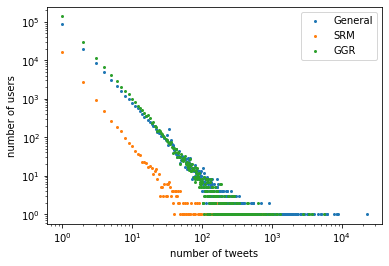

In [35]:
# distribution of tweeting activity

for value in ['General', 'SRM', 'GGR']:
    filtered_df = tweets_classified_df[tweets_classified_df[value] == 1]

    histogram = filtered_df['uid'].value_counts().value_counts()
    plt.scatter(histogram.index, histogram.values, s=4, label=value)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('number of users')
    plt.xlabel('number of tweets')
    plt.legend()
    #plt.savefig("figures/users/tweets_per_user_histogram.png", **savefig_settings)

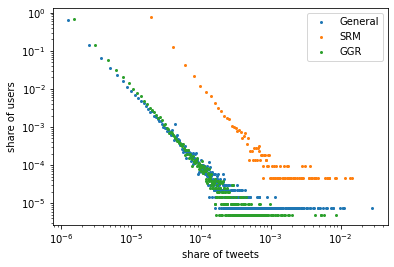

In [36]:
# distribution of tweeting activity

for value in ['General', 'SRM', 'GGR']:
    filtered_df = tweets_classified_df[tweets_classified_df[value] == 1]

    histogram = filtered_df['uid'].value_counts(normalize=True).value_counts(normalize=True)
    plt.scatter(histogram.index, histogram.values, s=4, label=value)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('share of users')
    plt.xlabel('share of tweets')
    plt.legend()
    #plt.savefig("figures/users/tweets_per_user_histogram.png", **savefig_settings)

## Difference in emotions and retweets for conspiracy vs. non-conspiracy

In [37]:
emotions_freq = tweets_classified_df.groupby('conspiracy-filter')['bertweet-emotions'].value_counts(normalize=True)
emotions_freq

conspiracy-filter  bertweet-emotions
False              others               0.851307
                   disgust              0.066382
                   joy                  0.036434
                   fear                 0.028325
                   anger                0.012803
                   surprise             0.003474
                   sadness              0.001274
True               others               0.795689
                   disgust              0.118164
                   anger                0.037632
                   fear                 0.020898
                   joy                  0.019612
                   surprise             0.005354
                   sadness              0.002650
Name: bertweet-emotions, dtype: float64

In [38]:
emotions_freq.loc[(True, )] / emotions_freq.loc[(False, )]

bertweet-emotions
anger       2.939235
disgust     1.780066
fear        0.737791
joy         0.538292
others      0.934667
sadness     2.080167
surprise    1.541236
Name: bertweet-emotions, dtype: float64

In [39]:
# avg retweets
tweets_classified_df.groupby('conspiracy-filter')['retweet_count'].mean()

conspiracy-filter
False    1.338549
True     1.169337
Name: retweet_count, dtype: float64

In [40]:
tweets_classified_df.groupby('conspiracy-filter')['like_count'].mean()

conspiracy-filter
False    3.26610
True     1.08472
Name: like_count, dtype: float64

In [41]:
tweets_classified_df.groupby('conspiracy-filter')['quote_count'].mean()

conspiracy-filter
False    0.139787
True     0.086582
Name: quote_count, dtype: float64

In [42]:
tweets_classified_df.groupby('conspiracy-filter')['reply_count'].mean()

conspiracy-filter
False    0.328954
True     0.241313
Name: reply_count, dtype: float64

## retweets and likes by group

In [43]:
for group in ['General', 'SRM', 'GGR']:
    print(group, tweets_classified_df.groupby(group)['retweet_count'].mean()[1])

General 0.7980861401755872
SRM 1.1586367585498776
GGR 1.9416603550314189


In [44]:
for group in ['General', 'SRM', 'GGR']:
    print(group, tweets_classified_df.groupby(group)['like_count'].mean()[1])

General 1.055733210932864
SRM 2.7264236632177554
GGR 5.154598665185949


In [45]:
tweets_classified_df.columns.to_list()

['tid',
 'uid',
 'created_at',
 'text',
 'cardiff-stance-climate',
 'cardiff-offensive',
 'cardiff-sentiment',
 'bertweet-sentiment',
 'geomotions-orig',
 'geomotions-ekman',
 'cardiff-emotion',
 'bertweet-emotions',
 'nrc',
 'nrc-highest',
 'nrc-score',
 'g_01',
 'g_02',
 'g_05',
 'g_06',
 's_01',
 's_02',
 's_21',
 's_22',
 's_27',
 's_04',
 's_07',
 's_09',
 's_20',
 's_23',
 's_24',
 's_10',
 's_11',
 's_25',
 's_30',
 's_12',
 's_14',
 's_16',
 's_17',
 's_18',
 's_19',
 's_29',
 'c_01',
 'c_02',
 'c_03',
 'c_04',
 'c_05',
 'c_06',
 'c_07',
 'c_08',
 'c_55',
 'c_10',
 'c_11',
 'c_12',
 'c_13',
 'c_14',
 'c_15',
 'c_16',
 'c_17',
 'c_18',
 'c_19',
 'c_54',
 'c_09',
 'c_20',
 'c_21',
 'c_22',
 'c_50',
 'c_23',
 'c_49',
 'c_24',
 'c_25',
 'c_26',
 'c_51',
 'c_27',
 'c_29',
 'c_30',
 'c_31',
 'c_32',
 'c_33',
 'c_36',
 'c_37',
 'c_38',
 'c_39',
 'c_40',
 'c_41',
 'c_42',
 'c_43',
 'c_52',
 'c_53',
 'c_44',
 'c_45',
 'c_46',
 'c_47',
 'c_48',
 'retweet_count',
 'reply_count',
 'like_co